# Pre-processing of SL System DESJ2038-4008
This notebook takes the drizzled HST images and extracts the information (e.g. cutout of image, PSF and noise estimates) to be used in the subsequent modelling process.

### import libraries

In [1]:
import numpy as np
import os
import h5py

import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

### read in data from fits files

In [2]:
system_name = 'DESJ2038-4008'

ra_str = '20:38:02.73'
dec_str = '-40:08:13.29'

# options for cutout
numPix = 96 #*8

system = StrongLensSystem(system_name)
system.add_info_attribute('ra_str', ra_str)
system.add_info_attribute('dec_str', dec_str)

image_name = 'F160W'
image_filename = 'DESJ2038-4008_F160W_drz_sci.fits'
wht_filename = "DESJ2038-4008_F160W_drz_wht.fits"
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print(base_path)

# import the data
local_filename = os.path.join(base_path, 'data', 'reduced_data', image_filename)
local_wht_filename = os.path.join(base_path, 'data', 'reduced_data', wht_filename)


# add image data instance (see astroObjectAnalyser)
system.add_image_data_init(image_name, local_filename=local_filename, local_psf_filename=None, 
                    local_wht_filename=local_wht_filename,
                       ra=system.ra, dec=system.dec, ra_cutout_cent=system.ra, dec_cutout_cent=system.dec,
                       cutout_scale=numPix, data_type='HST_new')

print(system.ra, system.dec)
print(system.ra_str, system.dec_str)

/Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling
(309.511375, -40.137025)
('20:38:02.73', '-40:08:13.29')


## show image and determine shift and positions of point sources

the center of the image is at pixel coordinates 912.937678, 845.645605.


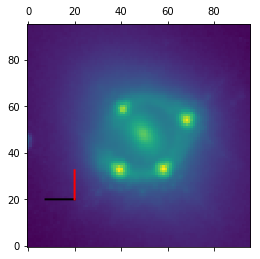

In [3]:

data_cutout = system.get_cutout_image(image_name, numPix, force=True)  # if force=True, a new cutout with the new options will be made

#%matplotlib notebook

plt.matshow(np.log10(data_cutout), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
plt.show()


Pixel size: 0.08 arcsec
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling/data/reduced_data/DESJ2038-4008_F160W_drz_sci.fits -c .pysex.sex -STARNNW_NAME .pysex.nnw -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -GAIN 5492.330935 -CATALOG_NAME .pysex.cat
Background mean: 0.23828, rms: 0.00883
the center of the image is at pixel coordinates 912.937678, 845.645605.
separate exposure map loaded


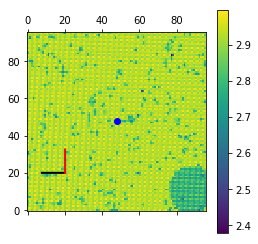

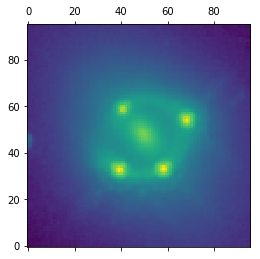

In [4]:
deltaPix, _ = system.get_pixel_scale(image_name)
deltaPix *= 3600  # convert into arcsec
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
# get mean and sigma_bkd of image (computed by SourceExtractor)
mean, sigma_b = system.get_background(image_name)
ccd_gain = system.get_CCD_gain(image_name)
print('Background mean: {:.5f}, rms: {:.5f}'.format(mean, sigma_b))

# we subtract the mean background estimate from the cutout image
data_reduced = (data_cutout - mean)#*mask_off


# get exposure time
exp_time = system.get_exposure_time(image_name)

# here we set the coordinate grid (rectangular)
ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(image_name)
x_at_radec_0, y_at_radec_0 = system.pixel_at_angle_0(image_name)
Matrix = system.get_transform_matrix_angle2pix(image_name)
Matrix_inv = system.get_transform_matrix_pix2angle(image_name)
cos_dec = np.cos(system.dec/360*2*np.pi)


# get weight map (effective exposure time per pixel)
wht_map = system.get_exposure_map(image_name)
# untis in pixels are originally electrons/s

# for numerics, replace 0 with small number
wht_map[wht_map <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times


plt.matshow(np.log10(wht_map), origin='lower')
plt.autoscale(False)

ra0, dec0 = system.pix2coord(image_name, 20, 20)
xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
 
x_0, y_0 = system.pixel_at_angle_0(image_name)
plt.plot(x_0, y_0, 'ob')
plt.colorbar()
plt.show()



plt.matshow(np.log10(data_reduced), origin='lower')
plt.show()

### PSF estimate

No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling/data/reduced_data/DESJ2038-4008_F160W_drz_sci.fits -c .pysex.sex -STARNNW_NAME .pysex.nnw -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -GAIN 5492.330935 -CATALOG_NAME .pysex.cat
{'ClassStarMin': 0.5, 'SizeMaxThresh': 5.174734830856323, 'EllipticityThresh': 0.1, 'MagMinThresh': 20.293926239013672, 'MagMaxThresh': 24.40574836730957, 'SizeMinThresh': 1.1747348308563232, 'ClassStarMax': 1.0}
(19, 'number of stars')


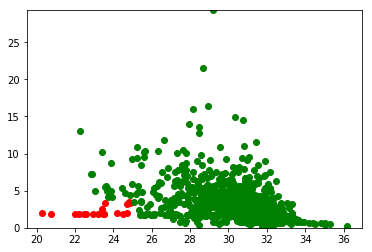

In [5]:
# options for PSF
psf_type ='pixel'
psf_size = 41
psf_size_large = 61
psf_symmetry = 4

# get SExtractor catalog
analysis = Analysis()
cat = system.get_cat(image_name)

# magnitude-size plot
mag = np.array(cat.data['MAG_BEST'],dtype=float)
mag[mag > 50] = np.mean(mag)
size = np.array(cat.data['FLUX_RADIUS'],dtype=float)

# select stars
kwargs_cuts = analysis.estimate_star_thresholds(cat)
print(kwargs_cuts)
kwargs_cuts['ClassStarMin'] = 0.1
kwargs_cuts['EllipticityThresh'] = 0.8
kwargs_cuts['MagMinThresh'] = 18
kwargs_cuts['MagMaxThresh'] = 25
kwargs_cuts['SizeMinThresh'] = 0.5
kwargs_cuts['SizeMaxThresh'] = 4
mask = analysis.find_objects(cat, kwargs_cuts)
print(np.sum(mask), 'number of stars')
plt.plot(mag[mask > 0], size[mask > 0], 'or')
plt.plot(mag[mask == 0], size[mask == 0], 'og')
plt.ylim([0, np.max(size)])
plt.show()


max iteration reached! stoping
(-348.56224134134123, 'reduced X^2 of best position')
max iteration reached! stoping
(-2248.971035735234, 'reduced X^2 of best position')
max iteration reached! stoping
(-448.77582737003144, 'reduced X^2 of best position')
max iteration reached! stoping
(-8422.513945725363, 'reduced X^2 of best position')
max iteration reached! stoping
(-1069.6685385138255, 'reduced X^2 of best position')
max iteration reached! stoping
(-453.99135548003034, 'reduced X^2 of best position')
max iteration reached! stoping
(-8502.027923369147, 'reduced X^2 of best position')
max iteration reached! stoping
(-24968.919433248957, 'reduced X^2 of best position')
max iteration reached! stoping
(-918.9972620243606, 'reduced X^2 of best position')
max iteration reached! stoping
(-419.58396545521066, 'reduced X^2 of best position')
max iteration reached! stoping
(-770.8460683364863, 'reduced X^2 of best position')
max iteration reached! stoping
(-7445.342638182661, 'reduced X^2 of be

/Users/ajshajib/mybin/AstroObjectAnalyser/astroObjectAnalyser/DataAnalysis/analysis.py:71: RuntimeWarning: invalid value encountered in log10
  im = ax1.matshow(np.log10(sym_shifted), origin='lower', vmax=vmax, vmin=vmin)
/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


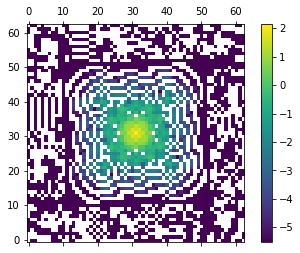

('=== object ===', 1, -0.8890169507438732, -0.07803739950395941)


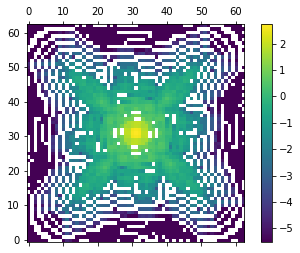

('=== object ===', 2, 0.12798022755328164, -0.4934647934428668)


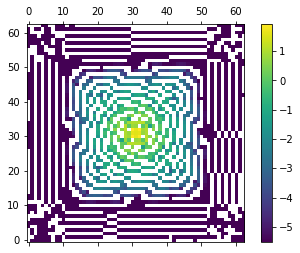

('=== object ===', 3, -0.24152708636568146, -0.39123901627744917)


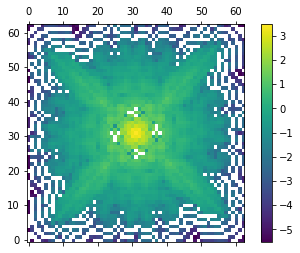

('=== object ===', 4, -0.22263180314067177, -0.49458942686103513)


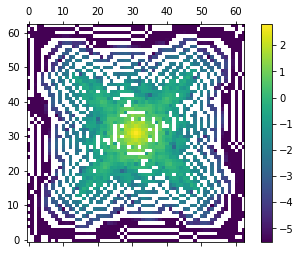

('=== object ===', 5, -0.89420314587297, -0.8394763115465333)


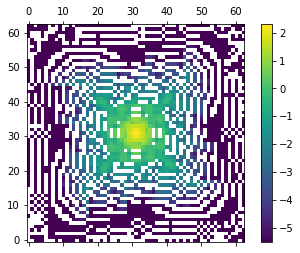

('=== object ===', 6, -0.6150556019440915, -0.39157469873863654)


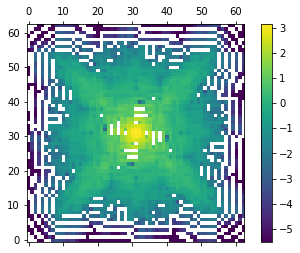

('=== object ===', 7, -51.24862593303674, 2.1582041621872854)


/Users/ajshajib/mybin/astrofunc/astrofunc/util.py:498: RuntimeWarning: invalid value encountered in divide
  kernel /= norm


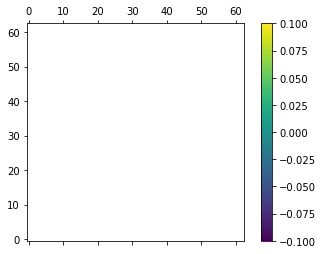

('=== object ===', 8, -0.4438523670773228, -1.023697157145888)


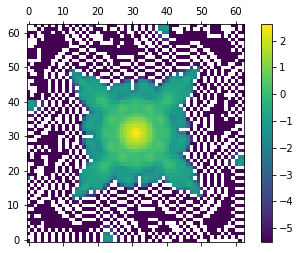

('=== object ===', 9, -0.40359319666362276, -0.32710341826074424)


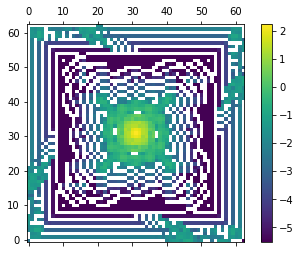

('=== object ===', 10, -0.748979295123473, -0.7595678951137147)


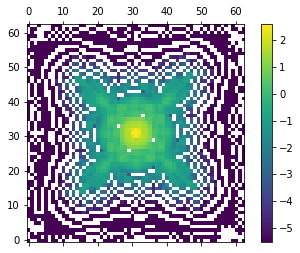

('=== object ===', 11, 0.41688674615458615, -1.2741220459449736)


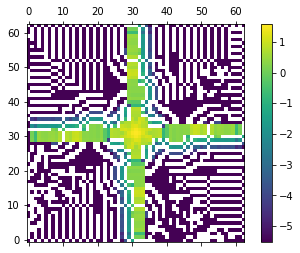

('=== object ===', 12, -0.5061354386216448, -0.9179922344501633)


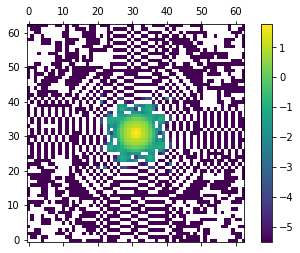

('=== object ===', 13, -0.4518933187082005, -0.4307561855464715)


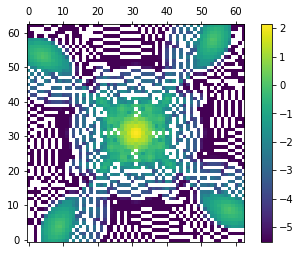

('=== object ===', 14, -0.17531835021979164, -0.7496683202728858)


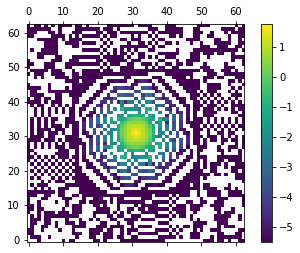

('=== object ===', 15, -0.5514505119053111, -0.2581265431789035)


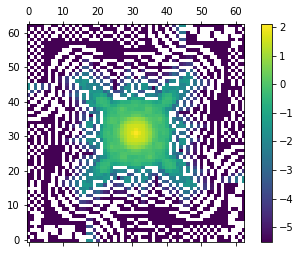

('=== object ===', 16, -0.10395827422144048, -0.07075541939433166)


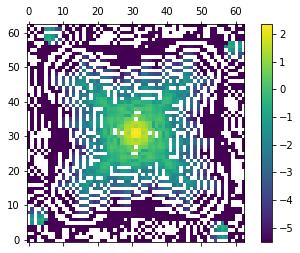

('=== object ===', 17, -0.16834953721216334, -0.20430233020710736)


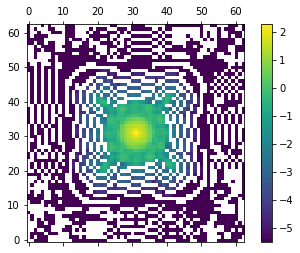

max iteration reached! stoping
(-291.62737588569325, 'reduced X^2 of best position')
max iteration reached! stoping
(-2246.6298466576254, 'reduced X^2 of best position')
max iteration reached! stoping
(-450.7914735936035, 'reduced X^2 of best position')
max iteration reached! stoping
(-8430.363341056465, 'reduced X^2 of best position')
max iteration reached! stoping
(-1076.3550721464949, 'reduced X^2 of best position')
max iteration reached! stoping
(-452.8723319418174, 'reduced X^2 of best position')
max iteration reached! stoping
(-8498.670624849032, 'reduced X^2 of best position')
max iteration reached! stoping
(-21616.385317633063, 'reduced X^2 of best position')
max iteration reached! stoping
(-918.7843568515822, 'reduced X^2 of best position')
max iteration reached! stoping
(-414.22235668741945, 'reduced X^2 of best position')
max iteration reached! stoping
(-772.1239596066785, 'reduced X^2 of best position')
max iteration reached! stoping
(-7640.846625982076, 'reduced X^2 of bes

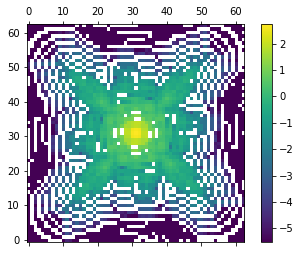

('=== object ===', 3, -0.24973481565112374, -0.3900147622837121)


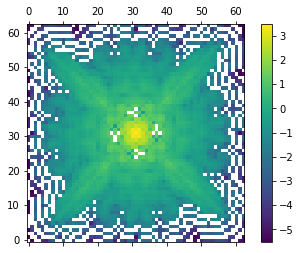

('=== object ===', 6, -0.6232508507766708, -0.39399096209824425)


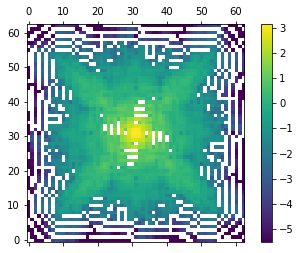

('=== object ===', 8, -0.4394872091288191, -1.0316709539098454)


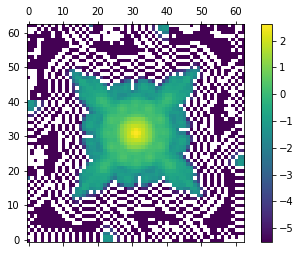

('=== object ===', 10, -0.7620935845902443, -0.7611134662329103)


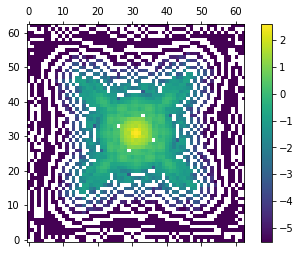

('=== object ===', 15, -0.5518978615711027, -0.26310889904001084)


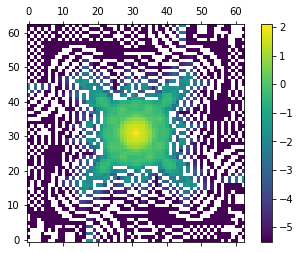

('=== object ===', 17, -0.15708343984789527, -0.20283827003908364)


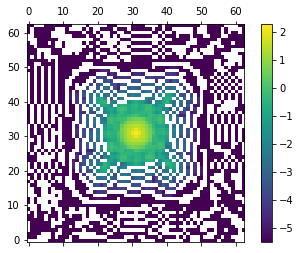

In [6]:
image_full = system.get_full_image(image_name)
image_full -= mean
kernel, mean_list, restrict_psf, star_list = analysis.get_psf(image_full, cat, mean, rms=sigma_b, poisson=exp_time,
                                psf_type='moffat', restrict_psf=None, kwargs_cut=kwargs_cuts, symmetry=psf_symmetry, 
                                                             cutfixed=int(psf_size_large/2)+1,
                                                             #inverse_shift=False
                                                             )
# restict psf fitting to subset of selected sources
true_list = [1, 3, 6, 8, 10, 15, 17]

for i in range(len(restrict_psf)):
    if i not in true_list:
        restrict_psf[i] = False
        
kernel, mean_list, restrict_psf, star_list_shifted = analysis.get_psf(image_full, cat, mean, rms=sigma_b,
                                poisson=exp_time, psf_type='moffat', restrict_psf=restrict_psf, kwargs_cut=kwargs_cuts,
                                                                      symmetry=psf_symmetry, 
                                                                      cutfixed=int(psf_size_large/2)+1,
                                                                      #inverse_shift=False
                                                                     )


Checking normalization. Sum of PSF pixels: 1.0


/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


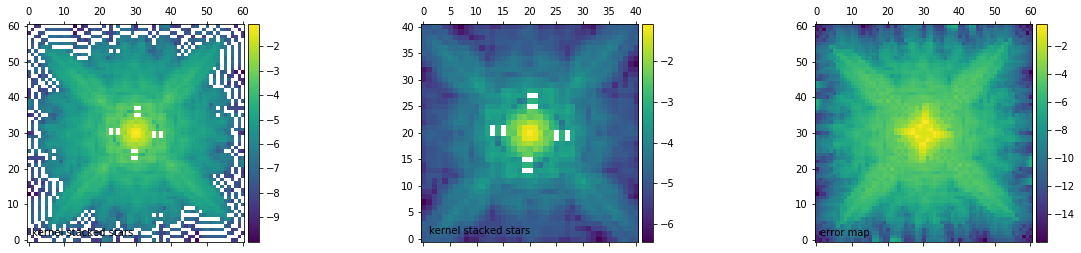

In [7]:
kernel_large_stack = kernel_util.cut_psf(kernel, psf_size=psf_size_large)
kernel_large_pixel = kernel #util.pixel_kernel(kernel)
kernel_pixel = kernel_util.cut_psf(kernel_large_pixel, psf_size=psf_size)

print('Checking normalization. Sum of PSF pixels: {}'.format(np.sum(kernel_large_stack)))

from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapelets = ShapeletSet()

kernel_list = shapelets.shapelet_basis_2d(num_order=10, beta=2, numPix=psf_size_large)
kernel_list.append(kernel_large_stack)
error_map = analysis.get_psf_errors(kernel_large_stack, sigma_b, star_list_shifted)

f, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)
ax = axes[0]
im = ax.matshow(np.log10(kernel_large_stack), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(kernel_pixel), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[2]
im = ax.matshow(np.log10(error_map), origin='lower')
ax.text(1, 1, 'error map')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

## Code to create a higher-resolution version of the PSF

Not used by Lenstronomy team, but by the glee team.

1.0


/Users/ajshajib/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


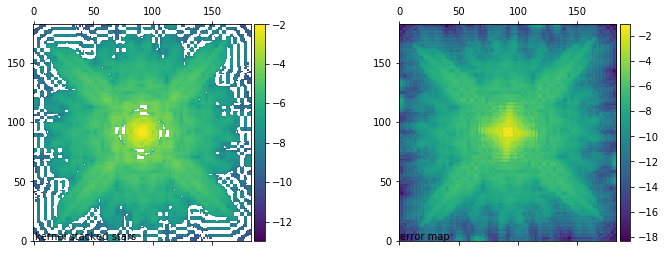

In [8]:
res = 3
kernel_large_stack_hires = kernel_util.subgrid_kernel(kernel_large_stack, subgrid_res=res)

print(np.sum(kernel_large_stack_hires))

star_list_shifted_hires = []

for star in star_list_shifted:
    star_list_shifted_hires.append(kernel_util.subgrid_kernel(star, subgrid_res=res))

kernel_list_hires = shapelets.shapelet_basis_2d(num_order=10, beta=2, numPix=psf_size_large*res)
kernel_list_hires.append(kernel_large_stack_hires)
error_map_hires = analysis.get_psf_errors(kernel_large_stack_hires, sigma_b, star_list_shifted_hires)

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)
ax = axes[0]
im = ax.matshow(np.log10(kernel_large_stack_hires), origin='lower')
ax.text(1, 1, 'kernel stacked stars')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax = axes[1]
im = ax.matshow(np.log10(error_map_hires), origin='lower')
ax.text(1, 1, 'error map')
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

In [9]:
psf_filename = 'psf_f160w_hires.hdf5'
local_psf_filename = os.path.join(base_path, 'data', psf_filename)
f = h5py.File(local_psf_filename, "w")
dset = f.create_dataset('kernel_point_source', data=kernel_large_stack_hires)
dset = f.create_dataset('psf_error_map', data=error_map_hires)
f.close()